# RAPIDS & Scanpy Single-Cell RNA-seq Workflow on mouse PFC cells

For demonstration purposes, we use a dataset of 1.3 M brain cells with Unified Virtual Memory to oversubscribe GPU memory.

## Import requirements

In [1]:
import numpy as np
import scanpy as sc
import anndata

import time
import os, wget

import cupy as cp
import cudf

from cuml.decomposition import PCA
from cuml.manifold import TSNE
from cuml.cluster import KMeans
from cuml.preprocessing import StandardScaler

import rapids_scanpy_funcs
import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')
import pandas as pd
from sh import gunzip
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from scipy.stats import ttest_ind, mannwhitneyu

We use the RAPIDS memory manager to enable Unified Virtual Memory management, which allows us to oversubscribe the GPU memory.

In [2]:
import rmm

rmm.reinitialize(managed_memory=True)
cp.cuda.set_allocator(rmm.rmm_cupy_allocator)

## Input data

In [3]:
D_R_mtx=pd.read_csv("/temp/drug_receptor_mtx.csv",index_col=0)
GPCR_type_df=pd.read_csv("/temp/GPCR_df.csv",index_col=0)

drug_list=D_R_mtx.index.to_list()
GPCR_list=["HTR1A","HTR1B","HTR1D","HTR1E","HTR2A","HTR2B","HTR2C",
"HTR3A","HTR4","HTR5A","HTR6","HTR7","DRD1","DRD2","DRD3","DRD4","DRD5",
"HRH1","HRH2","HRH3","CHRM1","CHRM2","CHRM3","CHRM4","CHRM5",
"ADRA1A","ADRA1B","ADRA2A","ADRA2B","ADRA2C","ADRB1","ADRB2"]
D_R_mtx.columns=GPCR_list

In [6]:
file_path="/temp/data/mouse_SFO/WT_SFO_adata.h5ad"
adata = anndata.read_h5ad(file_path)

GPCR_file_path="/temp/data/mouse_SFO/WT_SFO_GPCR_adata.h5ad"
GPCR_adata = anndata.read_h5ad(GPCR_file_path)

In [7]:
dir="/temp/data/mouse_SFO"
GPCR_adata_norm_df=pd.read_csv((os.path.join(dir,"GPCR_adata_norm_df.csv")),index_col=0)
new_columns = [col.split('_')[0] for col in GPCR_adata_norm_df.columns]
GPCR_adata_norm_df.columns=new_columns


In [8]:
GPCR_type_df=pd.read_csv("/temp/GPCR_df.csv",index_col=0)

In [9]:
sum(adata.obs['is_clz_selective'] ==1)

201

In [10]:
mask = adata.obs['is_clz_selective'] == 1

In [11]:
adata_clz_selective = adata[mask, :]
adata_not_clz_selective = adata[~mask, :]

GPCR_adata_clz_selective = GPCR_adata[mask, :]
GPCR_adata_not_clz_selective = GPCR_adata[~mask, :]

In [12]:
#print(adata_clz_selective.X)
print(adata_clz_selective.X.shape)
print(adata_not_clz_selective.X.shape)

[[-0.50072664 -0.1363981  -0.02198252 ... -0.56577265 -0.45820343
  -0.02979639]
 [-0.26232922 -0.08206867 -0.00787498 ... -0.3871118  -0.37652528
  -0.02864662]
 [ 0.49450108 -0.08074554 -0.00753141 ...  0.6635112  -0.37453607
  -0.02861862]
 ...
 [-1.5923544  -0.385174   -0.08658132 ...  0.70867866 -0.8322098
  -0.03506121]
 [ 1.3524996  -0.39867538 -0.09008717 ...  0.6642799  -0.8525076
  -0.03534694]
 [ 0.93632156  5.810613   -0.0702721  ...  3.007766    3.280911
  -0.033732  ]]
(201, 22414)
(7544, 22414)


In [13]:
GPCR_list2=GPCR_adata_norm_df.columns
GPCR_type_df=GPCR_type_df[GPCR_type_df.receptor_name.isin(GPCR_list2)]

In [15]:
import numpy as np

# 重複を避けるために使用するセット
unique_patterns_set = set()

# 結果を保存するための辞書
pattern_dict = {}

# 1万種類の独自の活性化パターンを生成
i = 0
while len(unique_patterns_set) < 10000:
    # ランダムな活性化パターンを生成（0はFalse、1はTrueとする）
    random_pattern = np.random.randint(2, size=len(GPCR_list2))
    # パターンを文字列に変換してハッシュ可能にする
    pattern_str = ''.join(map(str, random_pattern))

    # このパターンがまだ見つかっていない場合は保存
    if pattern_str not in unique_patterns_set:
        unique_patterns_set.add(pattern_str)
        pattern_dict[f"Pattern_{i+1}"] = {gpcr: bool(val) for gpcr, val in zip(GPCR_list2, random_pattern)}
        i += 1

# 最初の5つのパターンを出力して確認
for key in list(pattern_dict.keys())[:5]:
    print(f"{key}: {pattern_dict[key]}")
    


Pattern_1: {'HTR1A': True, 'HTR1B': False, 'HTR1D': False, 'HTR2A': False, 'HTR2B': True, 'HTR2C': False, 'HTR3A': False, 'HTR4': False, 'HTR5A': False, 'HTR6': False, 'HTR7': True, 'DRD1': False, 'DRD2': True, 'DRD3': True, 'DRD5': True, 'HRH1': False, 'HRH2': False, 'HRH3': False, 'CHRM1': False, 'CHRM2': True, 'CHRM3': False, 'ADRA1A': True, 'ADRA1B': True, 'ADRA2A': True, 'ADRA2B': False, 'ADRA2C': True, 'ADRB1': False, 'ADRB2': True}
Pattern_2: {'HTR1A': False, 'HTR1B': False, 'HTR1D': False, 'HTR2A': True, 'HTR2B': True, 'HTR2C': True, 'HTR3A': True, 'HTR4': False, 'HTR5A': True, 'HTR6': False, 'HTR7': True, 'DRD1': False, 'DRD2': False, 'DRD3': True, 'DRD5': False, 'HRH1': False, 'HRH2': True, 'HRH3': False, 'CHRM1': True, 'CHRM2': True, 'CHRM3': False, 'ADRA1A': False, 'ADRA1B': True, 'ADRA2A': False, 'ADRA2B': True, 'ADRA2C': True, 'ADRB1': True, 'ADRB2': True}
Pattern_3: {'HTR1A': False, 'HTR1B': False, 'HTR1D': True, 'HTR2A': False, 'HTR2B': False, 'HTR2C': True, 'HTR3A': Fa

In [16]:
# pattern_dictをデータフレームに変換
pattern_df = pd.DataFrame.from_dict(pattern_dict, orient='index').reset_index(drop=True)

In [17]:
clz_s=pd.DataFrame(GPCR_adata_clz_selective.X)
clz_s.columns=GPCR_list2

clz_nons=pd.DataFrame(GPCR_adata_not_clz_selective.X)
clz_nons.columns=GPCR_list2

In [18]:
Gs=GPCR_type_df[GPCR_type_df.type=="Gs"]["receptor_name"].values
Gi=GPCR_type_df[GPCR_type_df.type=="Gi"]["receptor_name"].values
Gq=GPCR_type_df[GPCR_type_df.type=="Gq"]["receptor_name"].values

In [19]:
#clz_s_Gs=(clz_s.loc[:,Gs]*pattern_df.loc[:,Gs]).sum(axis=0) 
clz_s_Gs=clz_s.loc[:,Gs].dot(pattern_df.loc[:,Gs].T)
clz_s_Gi=clz_s.loc[:,Gi].dot(pattern_df.loc[:,Gi].T)
clz_s_cAMP=clz_s_Gi-clz_s_Gs

clz_nons_Gs=clz_nons.loc[:,Gs].dot(pattern_df.loc[:,Gs].T)
clz_nons_Gi=clz_nons.loc[:,Gi].dot(pattern_df.loc[:,Gi].T)
clz_nons_cAMP=clz_nons_Gi-clz_nons_Gs

In [20]:
def compare_and_plot(df_A, df_B, top_x, test_type='t_test', show_first_graph=True):
    # 群内平均値の群間差を計算
    mean_A = df_A.mean()
    mean_B = df_B.mean()
    diff_mean = mean_A - mean_B
    
    # 活性化パターンを群間差が大きい順にソート
    sorted_patterns = diff_mean.sort_values(ascending=False).index[:top_x]

    # 統計テスト
    test_stats = []
    p_values = []
    for pattern in sorted_patterns:
        if test_type == 't_test':
            test_stat, p_val = ttest_ind(df_A.loc[:, pattern], df_B.loc[:, pattern])
        elif test_type == 'u_test':
            test_stat, p_val = mannwhitneyu(df_A.loc[:, pattern], df_B.loc[:, pattern])
        else:
            raise ValueError("Invalid test_type. Choose either 't_test' or 'u_test'")
        
        test_stats.append(test_stat)
        p_values.append(p_val)

    # 第1のグラフ（オプション）
    if show_first_graph:
        plt.figure(figsize=(10, 6))
        plt.bar(mean_A.index, mean_A.values, alpha=0.6, label='Group A')
        plt.bar(mean_B.index, mean_B.values, alpha=0.6, label='Group B')
        plt.title('Mean Activation by Pattern')
        plt.xlabel('Pattern')
        plt.ylabel('Mean Activation')
        plt.legend()
        plt.show()

    # Sort the top_x patterns by their diff_mean, in descending order
    sorted_by_diff_mean = diff_mean[sorted_patterns].sort_values(ascending=False).index

    plt.figure(figsize=(10, 6))
    plt.scatter(range(1, top_x + 1), diff_mean[sorted_by_diff_mean], c='blue', label='Difference in Mean Activation')
    plt.xticks(range(1, top_x + 1), labels=sorted_by_diff_mean, rotation=45)
    plt.title(f'Top {top_x} Patterns with Highest Difference in Mean Activation')
    plt.xlabel('Sorted Pattern')
    plt.ylabel('Difference in Mean Activation')
    plt.legend()
    plt.show()


    return sorted_patterns, test_stats, p_values


In [21]:
def plot_heatmap_and_average(pattern_df):
    # TrueとFalseを数値に変換（True=1, False=0）
    numeric_df = pattern_df.astype(int)

    # ヒートマップを描画
    plt.figure(figsize=(10, 14))
    plt.subplot(2, 1, 1)  # 2x1のグリッドの1番目
    plt.imshow(pattern_df, cmap='RdBu_r', aspect='auto')

    # カラーバーを追加
    plt.colorbar(ticks=[0, 1], label='Boolean Value')

    # 軸のラベルとタイトルを設定
    plt.title('Pattern vs Receptor Boolean Heatmap')
    plt.xlabel('Receptors')
    plt.ylabel('Patterns')

    # x軸とy軸の目盛りを設定
    plt.xticks(range(len(pattern_df.columns)), pattern_df.columns, rotation=90)
    plt.yticks(range(len(pattern_df.index)), pattern_df.index)

    # 各受容体の論理値の平均値をプロット
    plt.subplot(2, 1, 2)  # 2x1のグリッドの2番目
    average_values = numeric_df.mean()
    plt.bar(average_values.index, average_values.values, color='green')
    plt.title('Average Boolean Value per Receptor')
    plt.xlabel('Receptor')
    plt.ylabel('Average Boolean Value')
    plt.ylim(0, 1)
    plt.xticks(rotation=90)

    plt.tight_layout()
    plt.show()


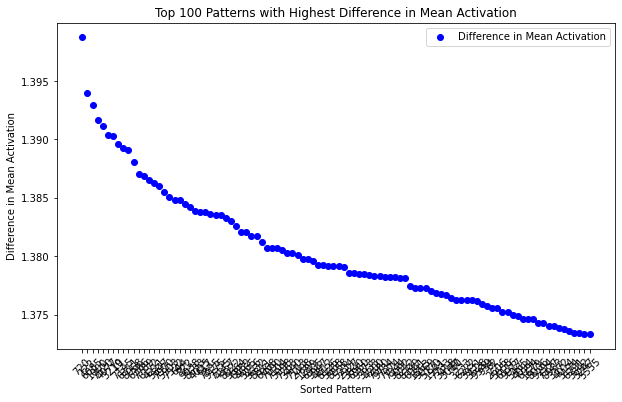

Statistical values for each pattern:
[30.36026887817267, 30.58663901439708, 30.032490687621944, 30.1588661887335, 29.70205762229296, 30.253369473007606, 30.243443637962983, 29.827452587142243, 30.357868805732657, 29.803060785905146, 29.268583824378723, 30.02860688484833, 29.885083741618587, 30.96014862852916, 28.902592812525796, 28.793599435047433, 29.466127858752177, 30.123866729740307, 31.303907314372843, 29.021175168057685, 29.891913684050117, 30.988902398472234, 29.51856822673711, 29.61103108324609, 29.054615154898414, 29.63174679697542, 29.800635218188223, 31.762554513553194, 31.594808151169676, 29.835597958044666, 31.587857833377708, 28.52687948754299, 29.218832321955254, 31.13385441663222, 30.71237276021351, 29.026189099535642, 30.36745878871614, 30.49422231759571, 29.684491885576914, 28.825641282089112, 30.891168519770854, 30.59996114290674, 30.030380210073357, 30.21880618200591, 29.51596967675946, 29.2287889674905, 29.37938919181486, 28.941985773108133, 30.571696226579935, 30.

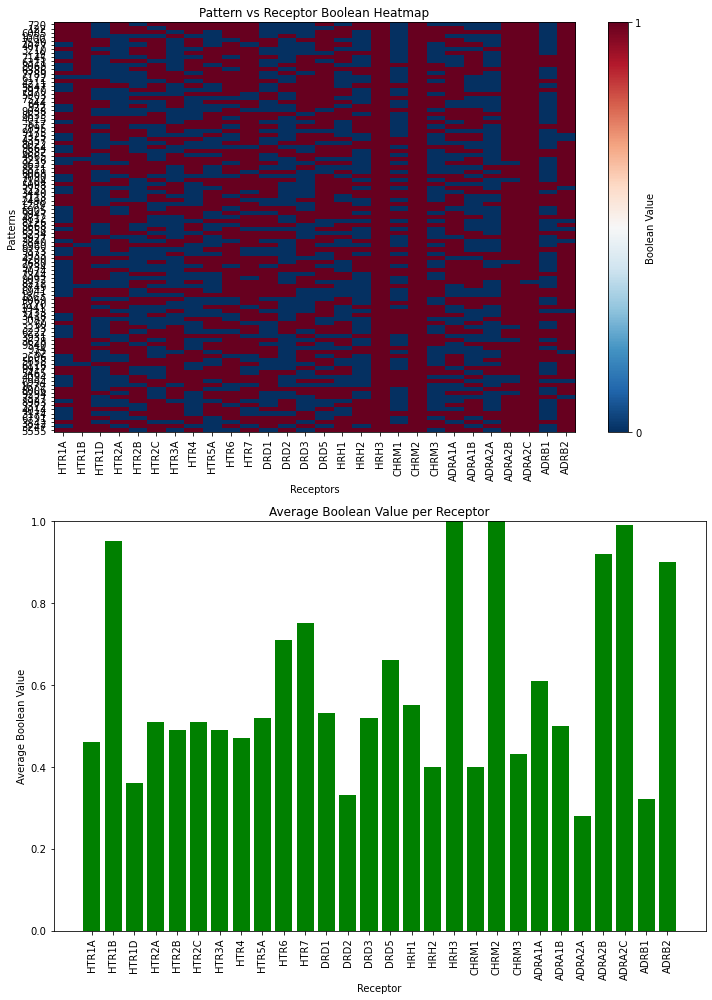

In [22]:
# 関数を呼び出してプロット、統計値とP値を受け取る
sorted_patterns, test_stats, p_values = compare_and_plot(clz_s_cAMP, clz_nons_cAMP,
                                                        top_x=100, test_type='t_test',show_first_graph=False)

print("Statistical values for each pattern:")
print(test_stats)

print("P-values for each pattern:")
print(p_values)

print("Top X patterns:")
print(sorted_patterns)

top_pattern=pattern_df.iloc[sorted_patterns,:]
# ヒートマップの描画
plot_heatmap_and_average(top_pattern)

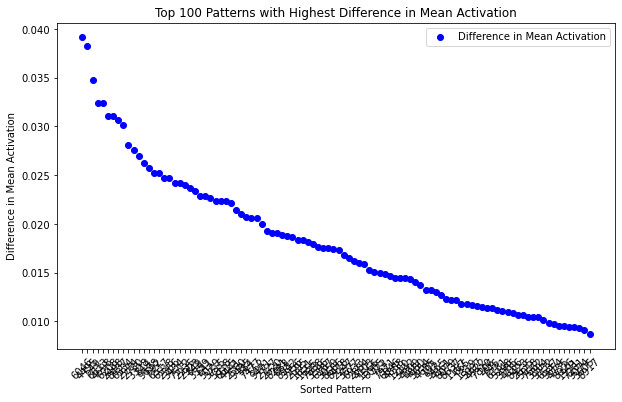

Statistical values for each pattern:
[2.1309117701877898, 2.2811760909872167, 1.7873435445161014, 2.060791185341207, 1.695128923766378, 1.4801844090236838, 1.4801844090236838, 1.4624653396125273, 1.375985299374135, 1.2806667528028883, 1.4665947901109244, 1.6361826256723246, 1.679698970103812, 1.4830798854163858, 1.4760224526099115, 1.12401705720173, 1.2880353065423387, 1.384030695684201, 1.104534611350589, 1.362100783072737, 1.4596453505814098, 1.113405211685425, 1.7183952959129225, 1.4163614616595863, 1.178071471407739, 1.0483947339734623, 1.416154580947572, 1.0065996917668374, 1.3862145850429493, 1.2961336059253397, 0.9422874299765498, 0.9906703830003327, 1.1262283684029124, 0.9680443299408099, 1.3943217640806083, 1.0396005049798709, 1.405575559235946, 0.8758594996059083, 1.4013812062388293, 0.8145686139846462, 1.6614890427704774, 0.8979799878630006, 1.1372395869450236, 1.0008673080413106, 1.0059360596157882, 1.113447683518185, 0.8959836621001687, 1.0302504169640654, 0.96001190610529

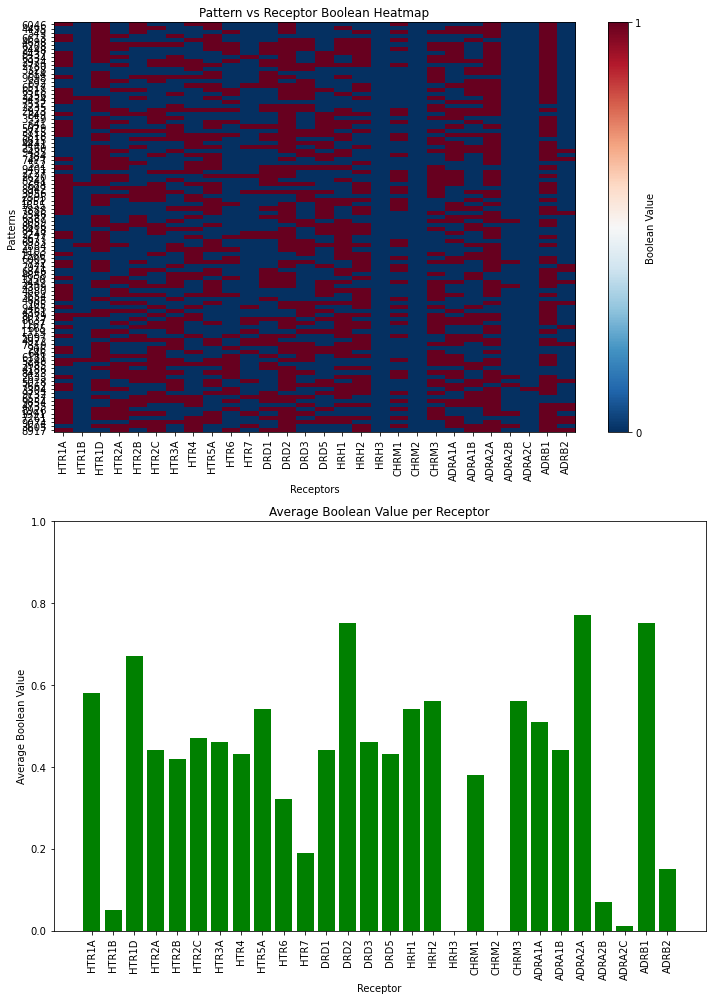

In [23]:
# 関数を呼び出してプロット、統計値とP値を受け取る
sorted_patterns, test_stats, p_values = compare_and_plot(clz_nons_cAMP, clz_s_cAMP,
                                                        top_x=100, test_type='t_test',show_first_graph=False)

print("Statistical values for each pattern:")
print(test_stats)

print("P-values for each pattern:")
print(p_values)

print("Top X patterns:")
print(sorted_patterns)

top_pattern=pattern_df.iloc[sorted_patterns,:]
plot_heatmap_and_average(top_pattern)

In [ ]:
important_receptor=["HTR1B","HRH3","CHRM2","ADRB2"]